### Generate Stock Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [2]:
# Parameters for synthetic stock data
S0 = 100            # initial stock price
mu = 0.05           # annual drift (expected return)
sigma = 0.2         # annual volatility
years = 3           # number of years to simulate
trading_days = 252  # trading days per year
T = years * trading_days  # total trading days
dt = 1 / trading_days     # time step in years

In [3]:
# Generate a date range for business days
dates = pd.date_range(start='2020-01-01', periods=T, freq='B')

In [4]:
# Pre-allocate an array for stock prices
prices = np.zeros(T)
prices[0] = S0

In [5]:
# Simulate stock prices using the GBM formula:
# S_t = S_{t-1} * exp((mu - 0.5*sigma^2)*dt + sigma * sqrt(dt) * Z)
for t in range(1, T):
    Z = np.random.normal()  # standard normal random number
    prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

In [6]:
# Create a DataFrame to store the synthetic stock data
synthetic_data = pd.DataFrame({
    'Date': dates,
    'Adj Close': prices
})

In [7]:
# Save the synthetic data to a CSV file
synthetic_data.to_csv("synthetic_stock.csv", index=False)

In [8]:
print("Synthetic stock data generated and saved as 'synthetic_stock.csv'.")
print(synthetic_data.head())

Synthetic stock data generated and saved as 'synthetic_stock.csv'.
        Date   Adj Close
0 2020-01-01  100.000000
1 2020-01-02   98.061597
2 2020-01-03   97.353911
3 2020-01-06   96.481990
4 2020-01-07   95.644509


### Descriptive Analysis

In [9]:
# Load the synthetic stock data (make sure synthetic_stock.csv is in your Colab working directory)
data = pd.read_csv("synthetic_stock.csv", parse_dates=['Date'])
print("Data head:")
print(data.head())

Data head:
        Date   Adj Close
0 2020-01-01  100.000000
1 2020-01-02   98.061597
2 2020-01-03   97.353911
3 2020-01-06   96.481990
4 2020-01-07   95.644509


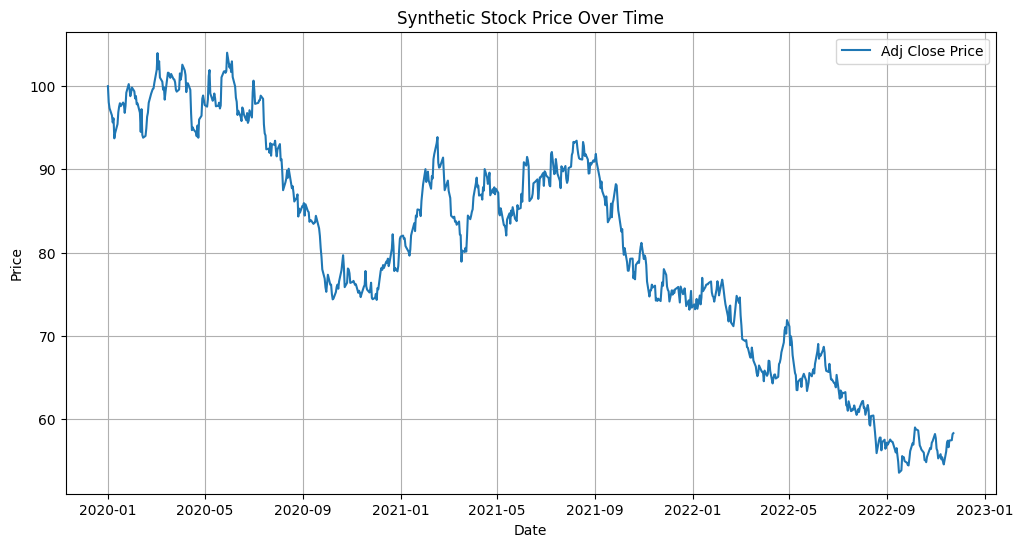

In [10]:
# Plot the stock price over time
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Adj Close"], label="Adj Close Price")
plt.title("Synthetic Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

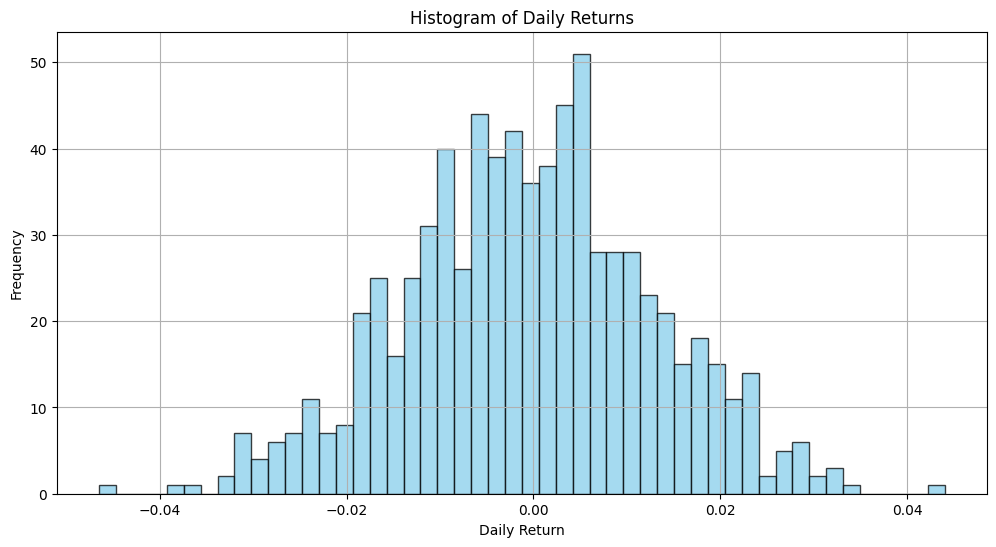

In [11]:
# Calculate daily returns
data["Daily Return"] = data["Adj Close"].pct_change()

# Plot histogram of daily returns
plt.figure(figsize=(12, 6))
plt.hist(data["Daily Return"].dropna(), bins=50, color="skyblue", edgecolor="black", alpha=0.75)
plt.title("Histogram of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

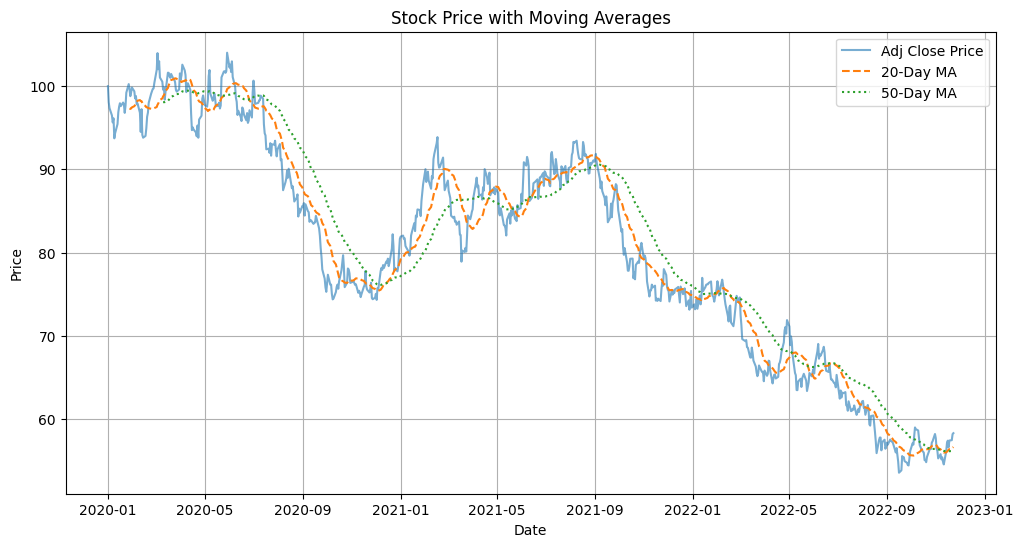

In [12]:
# Calculate moving averages
data["MA20"] = data["Adj Close"].rolling(window=20).mean()
data["MA50"] = data["Adj Close"].rolling(window=50).mean()

# Plot the stock price along with moving averages
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Adj Close"], label="Adj Close Price", alpha=0.6)
plt.plot(data["Date"], data["MA20"], label="20-Day MA", linestyle="--")
plt.plot(data["Date"], data["MA50"], label="50-Day MA", linestyle=":")
plt.title("Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

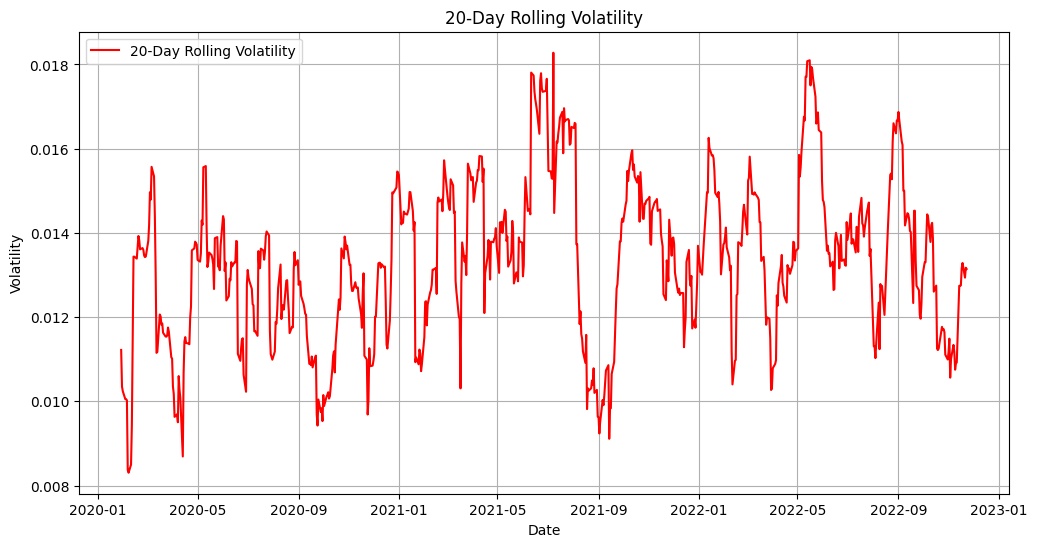

In [13]:
# Compute rolling volatility (20-day standard deviation of daily returns)
data["Volatility"] = data["Daily Return"].rolling(window=20).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(data["Date"], data["Volatility"], label="20-Day Rolling Volatility", color="red")
plt.title("20-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Print basic statistics
print("Average Daily Return:", data["Daily Return"].mean())
print("Average Volatility:", data["Volatility"].mean())

Average Daily Return: -0.0006260646992406885
Average Volatility: 0.013298229458124982


### Training the Model

In [15]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Hyperparameters
input_size = 1          # Using the Adjusted Close price
hidden_size = 32
num_layers = 1
num_actions = 2         # 0: continue, 1: stop
batch_size = 32
time_steps = 50         # Each episode is 50 consecutive days
gamma = 0.99            # Discount factor for RL
lr = 0.001              # Learning rate
replay_buffer_capacity = 10000
target_update_freq = 100  # Update target network every 100 training steps
num_training_steps = 2000  # Used in epsilon decay computation
strike = 100            # Strike price for computing reward

####Create Episodes (Filtration) from Stock Data


In [16]:
def create_episodes_from_stock_data(price_array, time_steps):
    """
    Create episodes using a sliding window.
    Each episode is a window of 'time_steps' consecutive prices.
    """
    episodes = []
    for i in range(len(price_array) - time_steps + 1):
        episode = price_array[i:i+time_steps].reshape(-1, 1)  # Shape: (time_steps, 1)
        episodes.append(episode)
    return np.array(episodes)

# Use the synthetic data loaded in Part 1
synthetic_prices = data["Adj Close"].values
episodes_dataset = create_episodes_from_stock_data(synthetic_prices, time_steps)
print(f"Total episodes from data: {len(episodes_dataset)}")

Total episodes from data: 707


#### Define the Model Architecture


In [17]:
class FiltrationEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(FiltrationEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        # x: (batch, time_steps, input_size)
        output, (hn, cn) = self.lstm(x)
        # Return the last hidden state as a summary of the filtration
        return hn[-1]

class StoppingPolicy(nn.Module):
    def __init__(self, hidden_size, num_actions=2):
        super(StoppingPolicy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions)  # Q-values for actions: 0 (continue), 1 (stop)
        )

    def forward(self, x):
        return self.fc(x)

class OptimalStoppingModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, num_actions=2):
        super(OptimalStoppingModel, self).__init__()
        self.encoder = FiltrationEncoder(input_size, hidden_size, num_layers)
        self.policy = StoppingPolicy(hidden_size, num_actions)

    def forward(self, x):
        encoded = self.encoder(x)
        q_values = self.policy(encoded)
        return q_values

#### Experience Replay Buffer


In [18]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

#### Reward Function

In [19]:
def compute_reward(price):
    # Reward for stopping: payoff = max(price - strike, 0)
    return np.maximum(price - strike, 0)

#### Instantiate Networks, Optimizer, and Replay Buffer


In [20]:
policy_net = OptimalStoppingModel(input_size, hidden_size, num_layers, num_actions)
target_net = OptimalStoppingModel(input_size, hidden_size, num_layers, num_actions)
target_net.load_state_dict(policy_net.state_dict())  # Initialize target network
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
criterion = nn.MSELoss()
replay_buffer = ReplayBuffer(replay_buffer_capacity)

#### Training Loop Using Historical Episodes (Offline RL)


In [21]:
steps_done = 0
loss_history = []
num_epochs = 10  # You can increase this for more training passes over the data

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Shuffle episodes for each epoch
    np.random.shuffle(episodes_dataset)

    # Process episodes in batches
    for start in range(0, len(episodes_dataset), batch_size):
        batch_episodes = episodes_dataset[start:start+batch_size]
        # Convert batch to torch tensor: shape (batch, time_steps, input_size)
        state = torch.FloatTensor(batch_episodes)

        # Use epsilon-greedy exploration (simulate decisions)
        epsilon = max(0.1, 1.0 - steps_done / (num_training_steps/2))

        # For each episode in the batch, decide on an action and store the transition.
        for i in range(state.size(0)):
            current_state = state[i:i+1, :, :]  # Shape: (1, time_steps, input_size)
            q_vals = policy_net(current_state)
            if random.random() < epsilon:
                action = random.randint(0, num_actions - 1)
            else:
                action = q_vals.argmax(dim=1).item()

            final_price = current_state[0, -1, 0].item()  # Last day's price in the episode
            reward = compute_reward(final_price) if action == 1 else -1.0
            # For simplicity, treat next_state as terminal (zeros) since the episode ends after decision.
            next_state = np.zeros_like(batch_episodes[i])
            done = True
            replay_buffer.push(current_state.numpy(), action, reward, next_state, done)

        # Train the network if there are enough samples in the replay buffer.
        if len(replay_buffer) >= batch_size:
            states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
            # Remove extra dimension (stored as shape (1, time_steps, input_size))
            states = torch.FloatTensor(states_np).squeeze(1)
            actions = torch.LongTensor(actions_np).unsqueeze(1)
            rewards = torch.FloatTensor(rewards_np).unsqueeze(1)
            next_states = torch.FloatTensor(next_states_np)  # Already shape: (batch, time_steps, input_size)
            dones = torch.FloatTensor(dones_np).unsqueeze(1)

            # Compute Q-values and the expected Q-values from the target network
            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
            expected_q = rewards + (gamma * next_q_values * (1 - dones))

            loss = criterion(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            steps_done += 1

            # Update target network every target_update_freq steps
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

    print(f"Epoch {epoch+1} complete.")

Epoch 1/10
Epoch 1 complete.
Epoch 2/10
Epoch 2 complete.
Epoch 3/10
Epoch 3 complete.
Epoch 4/10
Epoch 4 complete.
Epoch 5/10
Epoch 5 complete.
Epoch 6/10
Epoch 6 complete.
Epoch 7/10
Epoch 7 complete.
Epoch 8/10
Epoch 8 complete.
Epoch 9/10
Epoch 9 complete.
Epoch 10/10
Epoch 10 complete.


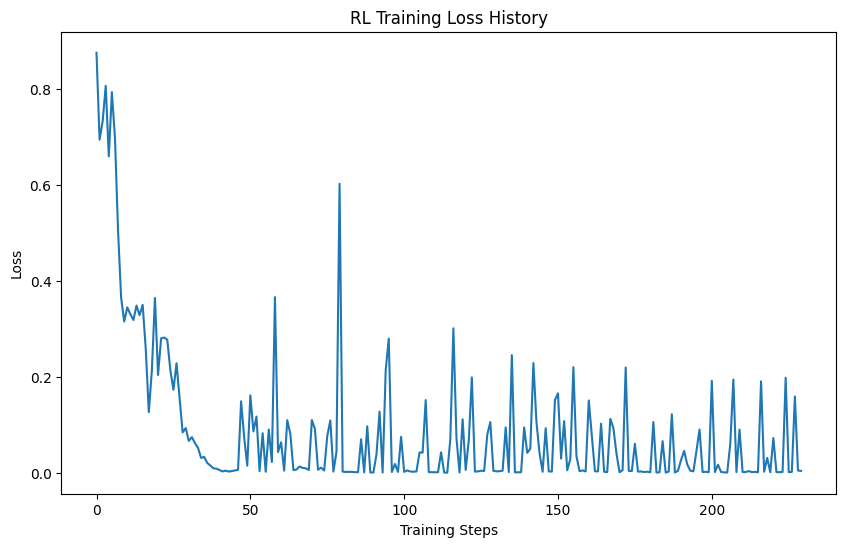

In [22]:
# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("RL Training Loss History")
plt.show()

### Testing the Model


#### Helper Function: Generate New Test Data


In [23]:
def generate_new_test_episodes(S0=100, mu=0.05, sigma=0.2, years=3, trading_days=252, time_steps=50):
    """
    Generate synthetic stock prices using GBM and create episodes using a sliding window.
    Returns an array of episodes with shape (num_episodes, time_steps, 1).
    """
    T = years * trading_days  # total trading days
    dt = 1 / trading_days
    prices = np.zeros(T)
    prices[0] = S0
    for t in range(1, T):
        z = np.random.normal()
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    episodes = []
    for i in range(len(prices) - time_steps + 1):
        episode = prices[i:i+time_steps].reshape(-1, 1)
        episodes.append(episode)
    return np.array(episodes)

# Generate new test episodes
new_test_episodes = generate_new_test_episodes()
print("New test episodes count:", len(new_test_episodes))

New test episodes count: 707


#### Define the Testing Function


In [24]:

def test_policy(policy_net, episodes_dataset, strike=100):
    """
    Evaluate the trained policy on a set of episodes.
    Returns:
      - accuracy: fraction of episodes where the agent's action matches a simple 'optimal' rule.
      - avg_payoff: average payoff achieved by the agent.
    The simple rule: if final price > strike, then the optimal action is 'stop' (1), else 'continue' (0).
    """
    policy_net.eval()  # set to evaluation mode
    correct = 0
    total = 0
    total_payoff = 0.0

    with torch.no_grad():
        for ep in episodes_dataset:
            # Each episode: (time_steps, 1); add batch dimension => (1, time_steps, 1)
            state = torch.FloatTensor(ep).unsqueeze(0)
            q_vals = policy_net(state)
            action = q_vals.argmax(dim=1).item()  # 0: continue, 1: stop

            final_price = ep[-1][0]  # last day's price
            payoff = max(final_price - strike, 0) if action == 1 else 0
            total_payoff += payoff

            # Simple optimal rule: stop (1) if final_price > strike, else continue (0)
            optimal_action = 1 if final_price > strike else 0
            if action == optimal_action:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0.0
    avg_payoff = total_payoff / total if total > 0 else 0.0
    return accuracy, avg_payoff

#### Evaluate the Trained Model





In [25]:
# -----------------------------
# -----------------------------
accuracy, avg_payoff = test_policy(policy_net, new_test_episodes, strike=strike)
error_rate = 1 - accuracy

print("Test Accuracy:", accuracy)
print("Test Error Rate:", error_rate)
print("Test Average Payoff:", avg_payoff)

Test Accuracy: 0.4752475247524752
Test Error Rate: 0.5247524752475248
Test Average Payoff: 6.181171131404643


## Two-Agent Optimal Stopping (Call + Put)

We add a dedicated put-option agent, a collaborative wrapper for both call and put agents.

In [26]:
import ipywidgets as widgets
from IPython.display import display, Markdown
import plotly.graph_objects as go

# Reusable payoff helpers for both option types

def call_reward(price, strike=strike):
    return float(np.maximum(price - strike, 0))


def put_reward(price, strike=strike):
    return float(np.maximum(strike - price, 0))

In [27]:
def train_optimal_stopping_agent(
    episodes_dataset,
    reward_fn,
    num_epochs=5,
    label="call",
    epsilon_floor=0.1,
):
    """
    Lightweight trainer that mirrors the earlier offline RL loop but allows
    swapping the reward for call/put options. Returns the trained policy net
    and the loss history for plotting.
    """
    policy_net = OptimalStoppingModel(input_size, hidden_size, num_layers, num_actions)
    target_net = OptimalStoppingModel(input_size, hidden_size, num_layers, num_actions)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    replay_buffer = ReplayBuffer(replay_buffer_capacity)

    steps_done = 0
    loss_history = []

    for epoch in range(num_epochs):
        np.random.shuffle(episodes_dataset)
        for start in range(0, len(episodes_dataset), batch_size):
            batch_episodes = episodes_dataset[start:start + batch_size]
            state = torch.FloatTensor(batch_episodes)
            epsilon = max(epsilon_floor, 1.0 - steps_done / (num_training_steps / 2))

            for i in range(state.size(0)):
                current_state = state[i:i + 1, :, :]
                q_vals = policy_net(current_state)
                action = random.randint(0, num_actions - 1) if random.random() < epsilon else q_vals.argmax(dim=1).item()

                final_price = current_state[0, -1, 0].item()
                reward = float(reward_fn(final_price)) if action == 1 else -1.0
                next_state = np.zeros_like(batch_episodes[i])
                done = True
                replay_buffer.push(current_state.numpy(), action, reward, next_state, done)

            if len(replay_buffer) >= batch_size:
                states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states_np).squeeze(1)
                actions = torch.LongTensor(actions_np).unsqueeze(1)
                rewards = torch.FloatTensor(rewards_np).unsqueeze(1)
                next_states = torch.FloatTensor(next_states_np)
                dones = torch.FloatTensor(dones_np).unsqueeze(1)

                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                expected_q = rewards + (gamma * next_q_values * (1 - dones))

                loss = criterion(q_values, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                loss_history.append(loss.item())
                steps_done += 1

                if steps_done % target_update_freq == 0:
                    target_net.load_state_dict(policy_net.state_dict())

    return policy_net, loss_history


def evaluate_agent(policy_net, episodes_dataset, strike=strike, option_type="call"):
    payoff_fn = call_reward if option_type == "call" else put_reward
    policy_net.eval()
    correct = 0
    total = 0
    total_payoff = 0.0

    with torch.no_grad():
        for ep in episodes_dataset:
            state = torch.FloatTensor(ep).unsqueeze(0)
            action = policy_net(state).argmax(dim=1).item()
            final_price = ep[-1][0]
            payoff = payoff_fn(final_price, strike=strike) if action == 1 else 0.0
            total_payoff += payoff

            optimal_action = 1 if (final_price > strike if option_type == "call" else final_price < strike) else 0
            if action == optimal_action:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0.0
    avg_payoff = total_payoff / total if total > 0 else 0.0
    return accuracy, avg_payoff

In [28]:
def collaborative_strategy(call_net, put_net, episodes_dataset, strike=strike):
    """
    Run both agents on each episode and capture their individual and combined
    payoffs. A combined stop occurs if either agent chooses to exercise.
    Returns the detailed dataframe plus combined payoff and stop rate.
    """
    rows = []
    for ep_idx, ep in enumerate(episodes_dataset):
        state = torch.FloatTensor(ep).unsqueeze(0)
        call_action = call_net(state).argmax(dim=1).item()
        put_action = put_net(state).argmax(dim=1).item()
        final_price = ep[-1][0]

        call_payoff = call_reward(final_price, strike=strike) if call_action == 1 else 0.0
        put_payoff = put_reward(final_price, strike=strike) if put_action == 1 else 0.0
        combined_payoff = call_payoff + put_payoff
        combined_stop = (call_action == 1) or (put_action == 1)

        rows.append({
            "episode": ep_idx,
            "final_price": final_price,
            "call_action": call_action,
            "put_action": put_action,
            "call_payoff": call_payoff,
            "put_payoff": put_payoff,
            "combined_payoff": combined_payoff,
            "combined_stop": combined_stop,
        })

    df = pd.DataFrame(rows)
    avg_combined_payoff = df["combined_payoff"].mean()
    avg_stop_rate = df["combined_stop"].mean()
    return df, avg_combined_payoff, avg_stop_rate

In [29]:
# Quick demonstration run to produce paired call/put agents

eval_episodes = new_test_episodes if "new_test_episodes" in globals() else episodes_dataset

call_policy_net, call_loss_history = train_optimal_stopping_agent(
    episodes_dataset,
    reward_fn=lambda p: call_reward(p, strike=strike),
    num_epochs=3,
    label="call",
)

put_policy_net, put_loss_history = train_optimal_stopping_agent(
    episodes_dataset,
    reward_fn=lambda p: put_reward(p, strike=strike),
    num_epochs=3,
    label="put",
)

call_acc, call_payoff = evaluate_agent(call_policy_net, eval_episodes, strike=strike, option_type="call")
put_acc, put_payoff = evaluate_agent(put_policy_net, eval_episodes, strike=strike, option_type="put")

collab_df, combined_payoff, combined_stop_rate = collaborative_strategy(
    call_policy_net, put_policy_net, eval_episodes, strike=strike
)

print(f"Call agent - accuracy: {call_acc:.3f}, avg payoff: {call_payoff:.3f}")
print(f"Put agent  - accuracy: {put_acc:.3f}, avg payoff: {put_payoff:.3f}")
print(f"Collaborative system - avg combined payoff: {combined_payoff:.3f}, stop rate: {combined_stop_rate:.3f}")

Call agent - accuracy: 0.475, avg payoff: 6.181
Put agent  - accuracy: 0.525, avg payoff: 4.117
Collaborative system - avg combined payoff: 10.298, stop rate: 1.000
